This project is done by Zhou Wentao(1003770) and Xiao Tianqi(1003684).

In [1]:
!git clone https://github.com/Mulie23/SP.git

Cloning into 'SP'...
remote: Enumerating objects: 5847, done.
remote: Counting objects: 100% (5847/5847), done.
remote: Compressing objects: 100% (5847/5847), done.
remote: Total 5847 (delta 0), reused 5847 (delta 0), pack-reused 0
Receiving objects: 100% (5847/5847), 38.20 MiB | 44.05 MiB/s, done.


In [2]:
cd /content/SP

/content/SP


Import the necessary libraries


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from data_util import *
import matplotlib.image as imgplt

Model for the neural network


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Dropout(p=0.5))
        
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Dropout(p=0.5))
        
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(256),
                                   nn.Dropout(p=0.5))

        self.conv4 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(256),
                                   nn.Dropout(p=0.5))
        
        self.fc1 = nn.Linear(256 * 9 * 9, 1024)
        self.drop1 = nn.Dropout(p = 0.8)
        self.fc2 = nn.Linear(1024, 256)
        self.drop2 = nn.Dropout(p = 0.8)
        self.fc3 = nn.Linear(256, 3)
        
        self.conv1.apply(init_weights)
        self.conv2.apply(init_weights)
        self.conv3.apply(init_weights)
        self.conv4.apply(init_weights)
        self.fc1.apply(init_weights)
        self.fc2.apply(init_weights)
        self.fc3.apply(init_weights)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim = 1)
        return output

Use Kaiming normal to initialise the data

In [42]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

The training function using the training set and test function using the test set


In [43]:
def train(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005)
    loss_func = torch.nn.CrossEntropyLoss()
    model.train()
    train_loss = 0
    train_acc = 0
    for batch_idx, (images_data, target_labels) in enumerate(train_loader):
        images_data, target_labels = images_data.to(device), target_labels.to(device)
        optimizer.zero_grad()
        out = model.forward(images_data)
        target = torch.reshape(target_labels.argmax(dim=1, keepdim=True).long(),(-1,))
        loss = loss_func(out, target)
        train_loss += loss.item()
        pred = torch.reshape(out.argmax(dim=1,keepdim=True).long(),(-1,))
        train_correct = (pred == target).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(ld_train)), train_acc / (len(ld_train))))
    train_loss_list.append(train_loss / (len(ld_train)))
    train_acc_list.append(train_acc / (len(ld_train)))

def test(model, test_loader):
    loss_func = torch.nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.
    test_acc = 0.
    with torch.no_grad():
      for batch_idx, (images_data, target_labels) in enumerate(test_loader):
          images_data, target_labels = images_data.to(device), target_labels.to(device)
          out = model.forward(images_data)
          target = torch.reshape(target_labels.argmax(dim=1, keepdim=True).long(),(-1,))
          test_loss += loss_func(out, target)
          pred = torch.reshape(out.argmax(dim=1,keepdim=True).long(),(-1,))
          num_correct = (pred == target).sum()
          test_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(test_loss / (len(ld_test)), test_acc / (len(ld_test))))
    test_loss_list.append(test_loss / (len(ld_test)))
    test_acc_list.append(test_acc / (len(ld_test)))   
    return  test_acc / (len(ld_test))

def test_on_val(model, val_loader):
    model.eval()
    val_acc = 0
    with torch.no_grad():
      for batch_idx, (images_data, target_labels) in enumerate(val_loader):
          images_data, target_labels = images_data.to(device), target_labels.to(device)
          out = model.forward(images_data)
          target = torch.reshape(target_labels.argmax(dim=1, keepdim=True).long(),(-1,))
          pred = torch.reshape(out.argmax(dim=1,keepdim=True).long(),(-1,))
          num_correct = (pred == target).sum()
          val_acc += num_correct.item()
    return  val_acc,target,pred

The plot of the dataset

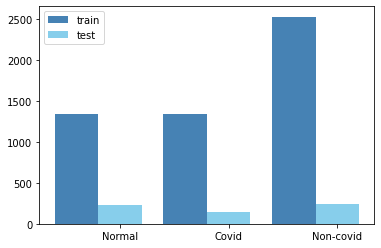

In [44]:
name_list = ['Normal','Covid','Non-covid']
train_num = [1341,1345,2530]
test_num = [234,139,242]
x = list(range(len(train_num)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, train_num, width=width, label='train',fc = 'steelblue')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_num, width=width, label='test',tick_label = name_list,fc = 'skyblue')
plt.legend()
plt.show()



Training and testing of the model, save the model for further use



In [46]:
device = 'cuda'
epoch = 40
ld_train = Lung_Train_Dataset()
ld_test = Lung_Test_Dataset()
ld_val = Lung_Val_Dataset()
bs_val = 16
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = False)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
model = Net().to(device)
#model = torch.load('model_best.pkl').to(device)
max_acc = 0
for i in range(0, epoch):
  print('epoch '+str(i+1))
  train(model, train_loader)
  accuracy = test(model, test_loader)
  if accuracy > max_acc:
    torch.save(model, 'model_best.pkl')
    max_acc = accuracy


epoch 1
Train Loss: 1.378697, Acc: 0.575920
Test Loss: 2.690269, Acc: 0.401626
epoch 2
Train Loss: 1.103635, Acc: 0.650115
Test Loss: 1.926345, Acc: 0.499187
epoch 3
Train Loss: 0.827026, Acc: 0.659701
Test Loss: 2.304216, Acc: 0.559350
epoch 4
Train Loss: 0.497537, Acc: 0.672354
Test Loss: 1.112813, Acc: 0.660163
epoch 5
Train Loss: 0.397034, Acc: 0.650307
Test Loss: 1.288671, Acc: 0.619512
epoch 6
Train Loss: 0.322582, Acc: 0.666411
Test Loss: 3.344583, Acc: 0.461789
epoch 7
Train Loss: 0.262789, Acc: 0.676380
Test Loss: 1.310360, Acc: 0.544715
epoch 8
Train Loss: 0.213854, Acc: 0.682899
Test Loss: 0.820282, Acc: 0.609756
epoch 9
Train Loss: 0.178282, Acc: 0.679640
Test Loss: 0.314037, Acc: 0.653659
epoch 10
Train Loss: 0.149862, Acc: 0.679256
Test Loss: 0.213659, Acc: 0.661789
epoch 11
Train Loss: 0.125906, Acc: 0.682132
Test Loss: 0.192110, Acc: 0.582114
epoch 12
Train Loss: 0.118456, Acc: 0.682324
Test Loss: 0.186114, Acc: 0.585366
epoch 13
Train Loss: 0.116099, Acc: 0.673696
Test

The graph of accuracy/loss against epochs

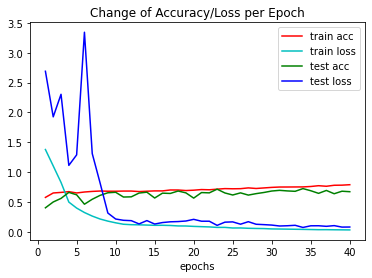

In [47]:
epochs = range(1,epoch+1)
plt.plot(epochs,train_acc_list,color='r',label='train acc')     
plt.plot(epochs,train_loss_list,color='c',label='train loss')  
plt.plot(epochs,test_acc_list,color='g',label='test acc')      
plt.plot(epochs,test_loss_list,color='b',label='test loss')
plt.xlabel('epochs')   
plt.title("Change of Accuracy/Loss per Epoch")      
plt.legend()           
plt.show()   


Testing the performance on the validation set

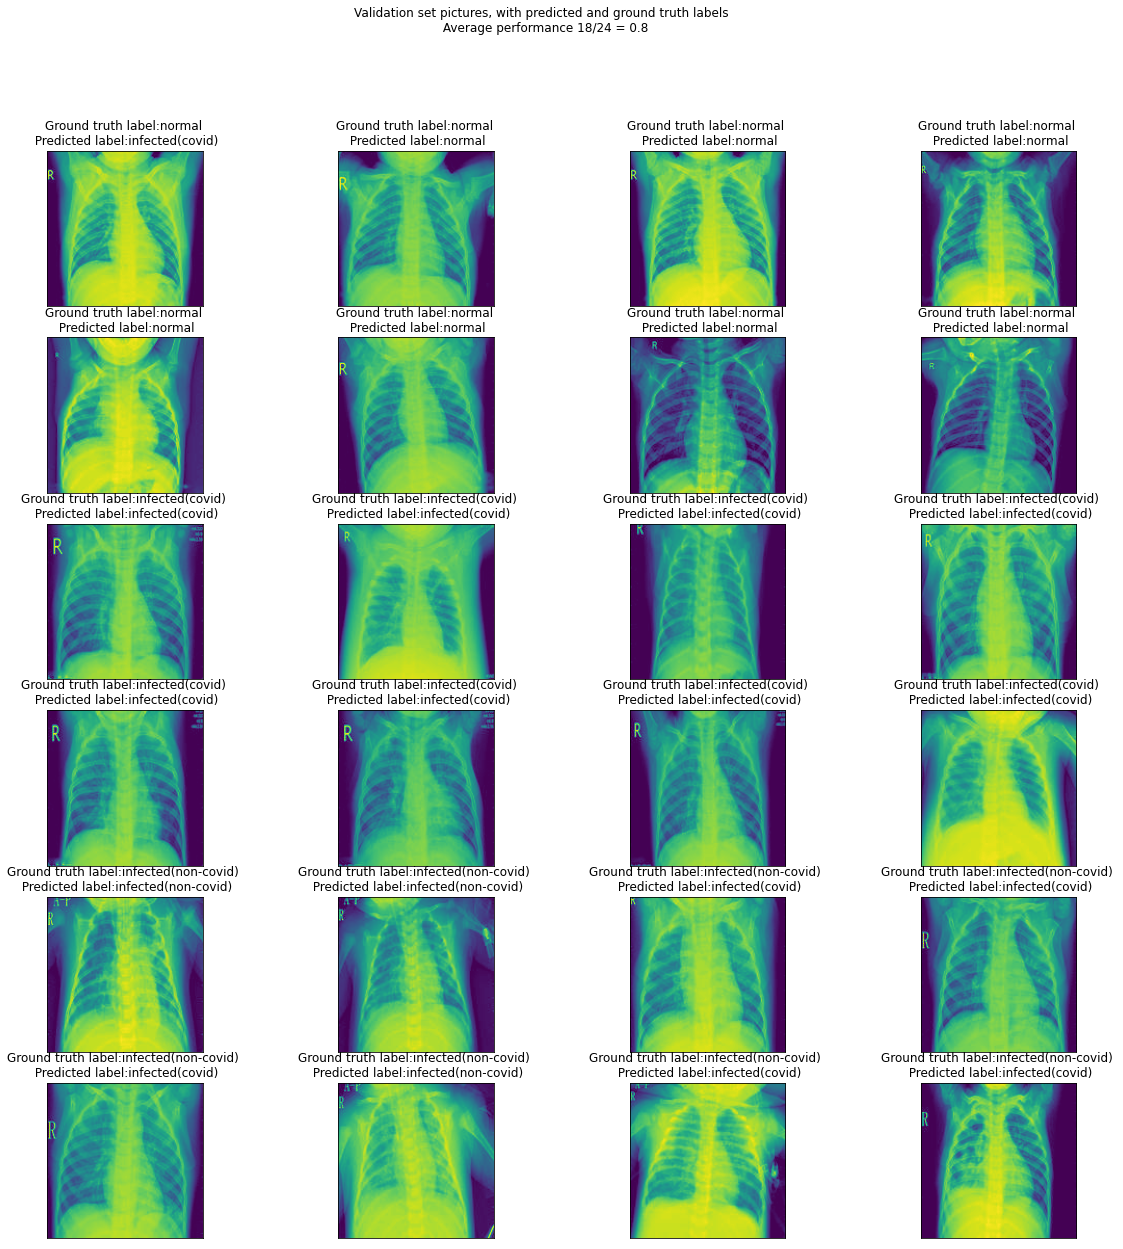

In [ ]:
img_path_list = []
for i in ('normal','covid','non-covid'):
  for j in range(0,8):
    path_to_file = 'dataset/val/%s/%d.jpg'%(i,j)
    img_path_list.append(path_to_file)
img_list = []
for i in img_path_list:
  x = imgplt.imread(i)
  img_list.append(x)
# print(img_list)
# print('Validation set pictures, with predicted and ground truth labels')
model = torch.load('model_best.pkl').to(device)
correct_num,target,predict = test_on_val(model,val_loader)
target_list = target.tolist()
predict_list = predict.tolist()
for i in range(len(target_list)):
  if target_list[i]==0:
    target_list[i]='normal'
  if target_list[i]==1:
    target_list[i]='infected(covid)'
  if target_list[i]==2:
    target_list[i]='infected(non-covid)'
  if predict_list[i]==0:
    predict_list[i]='normal'
  if predict_list[i]==1:
    predict_list[i]='infected(covid)'
  if predict_list[i]==2:
    predict_list[i]='infected(non-covid)' 
# print(target_list)
# print(predict_list)
fig = plt.figure(figsize = (20,20))
fig.suptitle('Validation set pictures, with predicted and ground truth labels \n Average performance %d/24 = %.1f' %(correct_num,correct_num/24))
for i in range(1,25):
    plt.subplot(6,4,i)
    plt.imshow(img_list[i-1])
    plt.title('Ground truth label:%s \n Predicted label:%s'%(target_list[i-1],predict_list[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()